In [1]:
#clock.py data preparation final

import requests
import pandas as pd
import numpy as np

def infect(source):
    '''
    Prepare base dataframe from csv. Add Wold count, null selection
    Returns timeindex and cols of countries saved as .csv
    '''
    df = pd.read_csv(source)
    df.loc[df['Province/State'] == 'Hong Kong', 'Country/Region'] = 'Hong Kong*'
    df.loc[df['Province/State'] == 'Macau', 'Country/Region'] = 'Macau*'
    df.drop(['Lat','Long','Province/State'], axis = 1, inplace=True)
    
    # add World count
    df = df.append( pd.Series(['World'], index = ['Country/Region']).append(df.sum()[1:]), ignore_index =True)
    
    df = df.groupby('Country/Region').sum()   
    df = df.T
    
    #add Null selection
    df['No selection'] = np.NaN
    
    #calculate daily increase
    for i in df.columns:
        df[i+'_daily'] = df[[i]].diff(axis = 0, periods = 1)
    
    df.columns.name = 'Country'
    df.index.name = 'Date'
    
    #df.to_csv('clean_'+source, index= False)
    return df

confirmed_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
dead_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#list of sources
pull = [confirmed_global,dead_global]
save = ['global_confirmed.csv',\
'global_dead.csv']

for p,s in zip(pull,save):
    r = requests.get(p).text
    with open(s, 'w') as f:
        f.write(r)

sick = infect('global_confirmed.csv')
dead = infect('global_dead.csv')
dead.columns = [i+'_dead' for i in dead.columns]

final = pd.concat((sick,dead), axis = 1) 
final.to_csv('final_data.csv')

In [6]:
#notebook version top notch version
from bokeh.io import show, output_notebook, curdoc
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler

import pandas as pd
import numpy as np
import datetime as dt
import requests
import json
#import psycopg2 
import os
import warnings
warnings.filterwarnings('ignore')

from bokeh.io import curdoc
from bokeh.plotting import figure
from bokeh.layouts import row, WidgetBox, column
from bokeh.models import HoverTool, Panel, NumeralTickFormatter, ColumnDataSource
from bokeh.models.widgets import CheckboxGroup, Tabs, Select, RadioButtonGroup


def modify(doc):
    
    def make_data(selection_sum, colour, radiob_act6):

        

        '''
        Creates a column dataset based on interactive filter selection
        Calculates rolling average trenline for daily graphs.
        Returns ColumnDataSource.data.keys(): index, Date, Country, value series
        '''


        # create list of column names form selection
        ##remove 'No selection' from the list if there are others selected
        if len(selection_sum) >1 :
            selection_sum = [i for i in selection_sum if i != 'No selection']
        else : selection_sum = selection_sum

        sel_daily = [i+'_daily' for i in list(set(selection_sum))]
        sel_dead = [i+'_dead' for i in selection_sum]
        sel_daily_dead = [i+'_dead' for i in sel_daily]
        sel_daily_roll = [i+'_roll' for i in sel_daily]
        sel_daily_dead_roll = [i+'_roll' for i in sel_daily_dead]

        df = sick[selection_sum + sel_daily + sel_dead+ sel_daily_dead]

        # trendline
        days = 7
        for i in sel_daily:
            df[i+'_roll'] = df[i].rolling(window = days).mean()
            df[i+'_dead_roll'] = df[i+'_dead'].rolling(window = days).mean()
        print('src',radiob_act6)
        #normalise with 100.000 population
        if radiob_act6 != 0:
            try:
                selection_sum.remove('No selection')
            except: None

            temp = pd.DataFrame()
            for i in selection_sum:

                n = (pop['data'][i])
                temp1 = df.loc[:,[ii for ii in df.columns if i in ii]] / (n)
                temp = pd.concat((temp, temp1), axis = 1) 
                s_cds = temp
            del temp
        else: s_cds = df.copy()

        del df

        s_cds.reset_index(inplace= True)
        s_cds['Date'] = pd.to_datetime(s_cds['Date'])

        #melts and combine sum values and diff values to a single df
        a1 = pd.melt(s_cds, id_vars = 'Date', value_vars = selection_sum, var_name = 'Country' )
        a2 = pd.melt(s_cds, id_vars = 'Date', value_vars = sel_daily, var_name = 'Country',value_name = 'value_day' )
        a3 = pd.melt(s_cds, id_vars = 'Date', value_vars = sel_dead, var_name = 'Country',value_name = 'value_dead' )
        a4 = pd.melt(s_cds, id_vars = 'Date', value_vars = sel_daily_dead, var_name = 'Country',value_name = 'value_day_dead' )
        a5 = pd.melt(s_cds, id_vars = 'Date', value_vars = sel_daily_roll, var_name = 'Country', value_name = 'value_day_roll')
        a6 = pd.melt(s_cds, id_vars = 'Date', value_vars = sel_daily_dead_roll, var_name = 'Country', value_name = 'value_day_dead_roll')


        s_cds = pd.concat([a1,a2['value_day'],
                           a3['value_dead'],
                           a4['value_day_dead'],
                           a5['value_day_roll'],
                           a6['value_day_dead_roll']], axis = 1, ignore_index= True)
        s_cds.columns = ['Date', 'Country', 'value','value_day','value_dead','value_day_dead','value_day_roll','value_day_dead_roll']

        #get rid of empty dates except if 'No selection' is there
        s_cds = s_cds.applymap(lambda x: np.NaN if x == 0 else x)
        if 'No selection' not in s_cds['Country'].unique():
            s_cds.dropna(axis = 1, how = 'all', inplace = True)

        # colourise
        s_cds['colour'] = s_cds['Country'].map(colour)

        return ColumnDataSource(s_cds)

    def make_plot(src, radio_act6):

        '''
        Create plot according to fed in cds
        ''' 
        
        print('plot', radio_act6)
        if radiob_act6 == 0:
            hover_fig = {'Date': '@Date{%Y-%m-%d}'
                        ,'Country': '@Country'
                        ,'Infected': '@value{,000,000}'}
            hover_fig1 = {'Date': '@Date{%Y-%m-%d}'
                        ,'Country': '@Country'
                        ,'Infected': '@value_day{0}'}
            hover_fig2 = {'Date': '@Date{%Y-%m-%d}'
                        ,'Country': '@Country'
                        ,'Dead': '@value_dead{0}'}
            hover_fig3 = {'Date': '@Date{%Y-%m-%d}'
                        ,'Country': '@Country'
                        ,'Dead': '@value_day_dead{0}'}
        else:
            hover_fig = {'Date': '@Date{%Y-%m-%d}'
                    ,'Country': '@Country'
                    ,'Infected': '@value{0}'}
            hover_fig1 = {'Date': '@Date{%Y-%m-%d}'
                        ,'Country': '@Country'
                        ,'Infected': '@value_day{0.0000}'}
            hover_fig2 = {'Date': '@Date{%Y-%m-%d}'
                        ,'Country': '@Country'
                        ,'Dead': '@value_dead{0}'}
            hover_fig3 = {'Date': '@Date{%Y-%m-%d}'
                        ,'Country': '@Country'
                        ,'Dead': '@value_day_dead{0.0000}'}

        fig_kwargs = {
                      'plot_width': 700
                      ,'plot_height': 200
                      ,'x_axis_type': 'datetime'
                      ,'background_fill_color': '#f1f5fc'
                      ,'border_fill_color' : '#f1f5fc'

                      }
        plot_kwargs = {'source': src
                       ,'hover_fill_color':'red'
                       ,'hover_color':'red'
                       ,'hover_alpha': 1
                       ,'color' : 'colour'
                       ,'size': 6
                       ,'selection_color':'red'
                       ,'nonselection_color':'colour'
                      }
        line_kwargs = {'color' : 'black'
                       ,'source':src
                       ,'line_width': 0.5   
                        }

        fig = figure(**fig_kwargs 
                    ,title = 'Registered Infected'
                    ,toolbar_location = 'above'
                    ,tools = ['pan','wheel_zoom','box_zoom','box_select', 'reset'])
        fig.diamond(x='Date',y='value', **plot_kwargs, legend='Country')

        fig.add_tools(HoverTool(tooltips=hover_fig,
                                formatters ={'@Date': 'datetime', '@value': 'numeral'},
                                mode = 'vline'))
        fig.legend.location = 'top_left'
        fig.yaxis.formatter=NumeralTickFormatter(format=",000,000") #format number display
        fig.ygrid.band_fill_color="olive"  #creates band colouring
        fig.ygrid.band_fill_alpha = 0.1
      ##################<<<<<<<<<<<<>>>>>>>>>>#################  
        fig1 = figure(**fig_kwargs
                     ,title = 'Daily increase')
        fig1.diamond(x='Date',y='value_day', **plot_kwargs)
        fig1.vline_stack(x='Date', stackers='value_day_roll', **line_kwargs)
        fig1.x_range = fig.x_range
        fig1.add_tools(HoverTool(tooltips=hover_fig1,
                                formatters ={'@Date': 'datetime', '@value_day': 'numeral'},
                                mode = 'mouse'))
        fig1.legend.location = 'top_left'
        fig1.yaxis.formatter=NumeralTickFormatter(format=",000,000") #format number display
        fig1.ygrid.band_fill_color="olive"  #creates band colouring
        fig1.ygrid.band_fill_alpha = 0.1
      ##################<<<<<<<<<<<<>>>>>>>>>>#################  
        fig2 = figure(**fig_kwargs
                     ,title = 'Total dead')
        fig2.diamond(x='Date',y='value_dead', **plot_kwargs)
        fig2.x_range = fig.x_range
        fig2.add_tools(HoverTool(tooltips=hover_fig2,
                                formatters ={'@Date': 'datetime', '@value_dead': 'numeral'},
                                mode = 'vline'))
        fig2.legend.location = 'top_left'
        fig2.yaxis.formatter=NumeralTickFormatter(format=",000,000") #format number display
        fig2.ygrid.band_fill_color="olive"  #creates band colouring
        fig2.ygrid.band_fill_alpha = 0.1            
      ##################<<<<<<<<<<<<>>>>>>>>>>#################  
        fig3 = figure(**fig_kwargs
                     ,title = 'Daily increase dead')
        fig3.diamond(x='Date',y='value_day_dead', **plot_kwargs)
        fig3.line(x='Date', y = 'value_day_dead_roll', **line_kwargs)
        fig3.x_range = fig.x_range
        fig3.add_tools(HoverTool(tooltips=hover_fig3,
                                formatters ={'@Date': 'datetime', '@value_day_dead': 'numeral'},
                                mode = 'mouse'))
        fig3.legend.location = 'top_left'
        fig3.yaxis.formatter=NumeralTickFormatter(format=",000,000") #format number display
        fig3.ygrid.band_fill_color="olive"  #creates band colouring
        fig3.ygrid.band_fill_alpha = 0.1                 



        layout1 =column(fig,fig1,fig2,fig3)
        layout2 =row(column(fig,fig1),column(fig2,fig3))
        return layout1,layout2

    def update(attr, old, new):


        chkbox_act1 = [checkbox_group1.labels[i] for i in checkbox_group1.active]
        chkbox_act2 = [checkbox_group2.labels[i] for i in checkbox_group2.active]
        drpbox_act3 = [drop_box_group3.value]
        drpbox_act4 = [drop_box_group4.value]
        drpbox_act5 = [drop_box_group5.value]
        radiob_act6 = radiobuttgroup6.active
        selection_sum = chkbox_act1+chkbox_act2+drpbox_act3+drpbox_act4+drpbox_act5
        us = [chkbox_act1,chkbox_act2,drpbox_act3,drpbox_act4,drpbox_act5]
        selection_sum = list(set(selection_sum))

        #keeping existing colours
        colour_list = ['#1f77b4','#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
        old_colour = {i:c for i,c in zip(src.data['Country'],src.data['colour'])}
        colour = {}
        for i in selection_sum:
            if i in old_colour.keys():
                colour[i] = old_colour[i]
                colour_list.remove(old_colour[i])
        for i, n in enumerate(selection_sum):
            if n not in colour.keys():
                colour[n] = colour_list[i]

        new_src = make_data(selection_sum, colour, radiob_act6)            
        src.data.update(new_src.data)
        fig = make_plot(src,radio_act6)
        del new_src
        print('up',radiob_act6)
        return fig
     
    #data acquisition
    #sick = connect()
   
    sick = pd.read_csv('/home/trismegistos/Documents/DA/projectek/CoronaV_Countries/published/final_data.csv', index_col = 'Date')
    pop = json.load(open('population_covid.json'))
    col_list = [ i for i in sick.columns if 'dead' not in i and 'daily' not in i]
    colour_list = ['#1f77b4','#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
    
    
    #make selection list excuding checkbox values
    dropdown_list = ['No selection'] + [i for i in col_list \
                    if i not in ['No selection', 'World', 'China', 'US', 'United Kingdom','Korea, South','Italy']]

    checkbox_group1 = CheckboxGroup(labels=['World','China','US'], active=[0])
    checkbox_group2 = CheckboxGroup(labels=['United Kingdom','Italy','Korea, South'], active= [0])
    drop_box_group3 = Select(title="Select country",value='No selection',options=dropdown_list)
    drop_box_group4 = Select(title="Select country",value='No selection',options=dropdown_list)
    drop_box_group5 = Select(title="Select country",value='No selection',options=dropdown_list)
    radiobuttgroup6 = RadioButtonGroup(labels=['Absolute', 'Normalized'], active=1)

    checkbox_group1.on_change('active', update)
    checkbox_group2.on_change('active', update)
    drop_box_group3.on_change('value', update)
    drop_box_group4.on_change('value', update)
    drop_box_group5.on_change('value', update)
    radiobuttgroup6.on_change('active', update)


    ctrl1 = WidgetBox(checkbox_group1, sizing_mode = 'fixed', height= 80, width = 120) 
    ctrl2 = WidgetBox(checkbox_group2, sizing_mode = 'fixed', height= 80, width = 120)
    ctrl3 = WidgetBox(drop_box_group3, sizing_mode = 'fixed', height= 80, width = 120)
    ctrl4 = WidgetBox(drop_box_group4, sizing_mode = 'fixed', height= 80, width = 120)
    ctrl5 = WidgetBox(drop_box_group5, sizing_mode = 'fixed', height= 80, width = 120)
    ctrl6 = WidgetBox(radiobuttgroup6, sizing_mode = 'fixed', height= 80, width = 120)


    start_sel1 = [checkbox_group1.labels[i] for i in checkbox_group1.active]
    start_sel2 = [checkbox_group2.labels[i] for i in checkbox_group2.active]
    start_sel3 = [drop_box_group3.value]
    start_sel4 = [drop_box_group4.value]
    start_sel5 = [drop_box_group5.value]
    start_act6 = radiobuttgroup6.active
    start_sum  = start_sel1 + start_sel2 +start_sel3 + start_sel4 + start_sel5
    colour = {'World':'#1f77b4', 'United Kingdom':'#ff7f0e'}
    
    src = make_data(start_sum, colour, start_act6)
    fig = make_plot(src, start_act6)

    coLayout = column(row(ctrl1,ctrl2, ctrl3, ctrl4,ctrl5, ctrl6),fig[0])
    roLayout = column(row(ctrl1,ctrl2, ctrl3, ctrl4,ctrl5, ctrl6),fig[1])
    colPanel = Panel(child = coLayout, title = '1x4 Layout')
    rowPanel = Panel(child = roLayout, title = '2x2 Layout')
    tabs = Tabs(tabs=[colPanel,rowPanel])
    
    doc.add_root(tabs)
    return doc


# Set up an application
output_notebook()
handler = FunctionHandler(modify)
app = Application(handler)

show(app)

Loading BokehJS ...

src 1
plot 1


ERROR:bokeh.server.protocol_handler:error handling message Message 'PATCH-DOC' (revision 1) content: {'events': [{'kind': 'ModelChanged', 'model': {'type': 'RadioButtonGroup', 'id': '2964'}, 'attr': 'active', 'new': 0}], 'references': []}: NameError("name 'radio_act6' is not defined")


src 0


ERROR:bokeh.server.protocol_handler:error handling message Message 'PATCH-DOC' (revision 1) content: {'events': [{'kind': 'ModelChanged', 'model': {'type': 'RadioButtonGroup', 'id': '2964'}, 'attr': 'active', 'new': 1}], 'references': []}: NameError("name 'radio_act6' is not defined")


src 1


In [17]:
sick = pd.read_csv('final_data.csv', index_col = 'Date')
pop = json.load(open('population_covid.json'))
col_list = [ i for i in sick.columns if 'dead' not in i and 'daily' not in i]
colour_list = ['#1f77b4','#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
colour = {'US': '#1f77b4', 'United Kingdom': '#ff7f0e'}

In [5]:
radiob_act6

0

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sick = pd.read_csv('final_data.csv', index_col = 'Date')
sel_daily = ['US_daily', 'China_daily']

df0 =sick[sel_daily].fillna(0)

for i in sel_daily:

    df = sick[[i]].fillna(0)
    X = np.arange(len(df)).reshape(-1,1)
    y = df.values.reshape(-1,1)
    
    #Standardizatio
    st = StandardScaler()
    sty = StandardScaler()
    X = st.fit_transform(X)
    y = sty.fit_transform(y)
    
    
    reg = SVR(kernel = 'rbf',coef0=0.1, epsilon=0.02)
    reg.fit(X,y)
    pred = reg.predict(X)
    
    df0[i+'_trend'] = sty.inverse_transform(pred)
    

/home/trismegistos/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/trismegistos/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [123]:
#df0[:5]

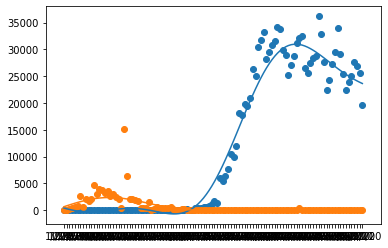

In [9]:
x = df0.index
plt.scatter(x,df0['US_daily'])
plt.scatter(x,df0['China_daily'])
plt.plot(x,df0['US_daily_trend'])
plt.plot(x,df0['China_daily_trend'])
plt.show()

In [10]:
test = sick[['China_daily']].dropna()
test['roll'] = test.rolling(window = 7).mean()
test.fillna(0.0)

X = np.arange(len(test)).reshape(-1,1)
y = test['China_daily'].values.reshape(-1,1)
X = st.fit_transform(X)
y = sty.fit_transform(y)

In [11]:

from sklearn.svm import SVR
reg = SVR(kernel = 'rbf',coef0=0, epsilon=0)
reg.fit(X,y)

/home/trismegistos/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0, degree=3, epsilon=0,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [12]:
test['reg'] = sty.inverse_transform(reg.predict(X))
test

,China_daily,roll,reg
Date,,,
1/23/20,92.0,NaN,1057.562153
1/24/20,277.0,NaN,1199.192452
1/25/20,483.0,NaN,1336.661290
1/26/20,663.0,NaN,1468.758440
1/27/20,801.0,NaN,1594.308614
...,...,...,...
5/6/20,2.0,3.285714,1.743145
5/7/20,1.0,1.714286,2.701725
5/8/20,1.0,1.714286,4.203535


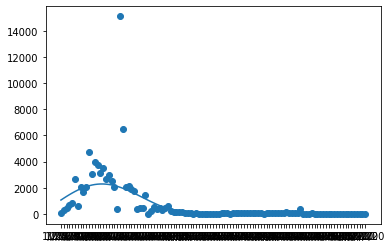

In [13]:
'''import matplotlib.pyplot as plt
plt.scatter(st.inverse_transform(X),sty.inverse_transform(y))
plt.plot(st.inverse_transform(X), sty.inverse_transform(test['reg']))
plt.show()'''

import matplotlib.pyplot as plt
plt.scatter(test.index, test['China_daily'])
plt.plot(test.index, test['reg'])
plt.show()

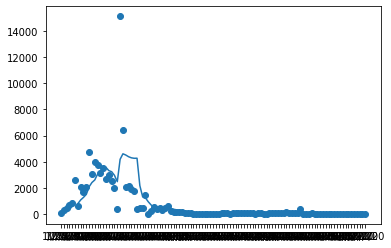

In [15]:
plt.scatter(test.index, test['China_daily'])
plt.plot(test.index, test['roll'])
plt.show()

In [ ]:
pd.read_csv()